In [81]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Load Data

In [82]:
transit_survey_video = pd.read_csv('Data/transit_survey_with minute and video counts.csv')

transit_survey_video['post_video'] = 0
transit_survey_video.loc[transit_survey_video['count - video (past 12 months)']>=6, 'post_video'] = 1
transit_survey_video.head()

responded = transit_survey_video[transit_survey_video['survey_response'] == 1]
no_response = transit_survey_video[transit_survey_video['survey_response'] == 0]

posted = transit_survey_video[transit_survey_video['minute_posted'] == 1]
no_posted = transit_survey_video[transit_survey_video['minute_posted'] == 0]

In [83]:
len(posted)

213

In [84]:
print ('population mean: ', np.mean(transit_survey_video['pop']))
print ('revenue mean: ', np.mean(transit_survey_video['revenue']))
print ('VOMS mean: ', np.mean(transit_survey_video['VOMS']))
print ('area mean: ', np.mean(transit_survey_video['mile']))

transit_survey_video['OrgType'].value_counts()

population mean:  707327.2446043165
revenue mean:  54083088.541666664
VOMS mean:  75.40106951871658
area mean:  355.1870503597122


Local Government             119
Independent Public Agency     74
MPO/RTPA                      26
Other                          7
Name: OrgType, dtype: int64

# Data Exploratory

Text(0.5, 1.0, 'Number of video posted')

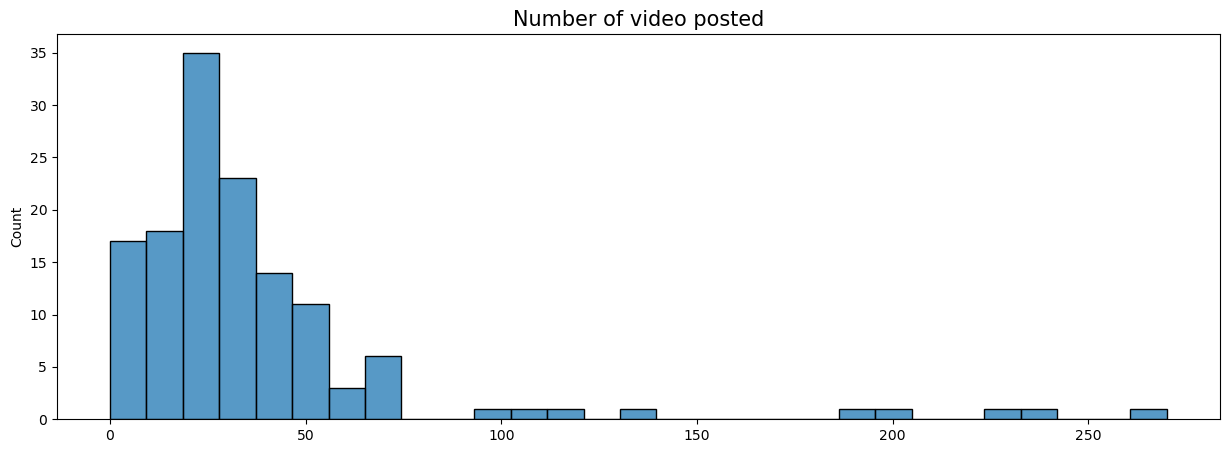

In [85]:
# Number of videos posted in the past 12 months
plt.figure(figsize = (15,5))
sns.histplot(data = np.array(transit_survey_video['count - video (past 12 months)']))
plt.title('Number of video posted', fontsize = 15)

# Survey Result

## EDA

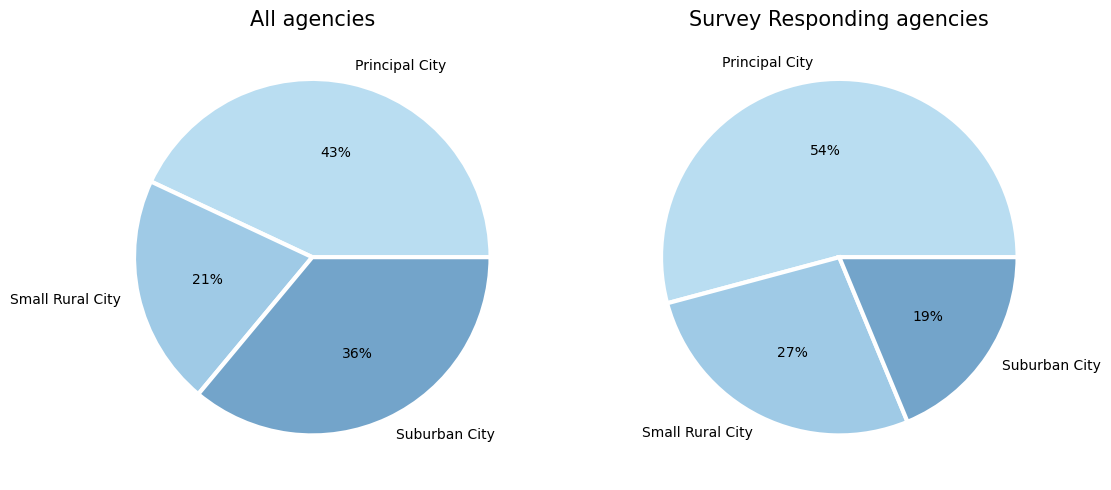

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plt.subplot(121)
plt.pie(transit_survey_video['id'].value_counts().sort_index(), 
    labels = transit_survey_video['id'].value_counts().sort_index().index.tolist(), 
    autopct='%.0f%%', 
    wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
    colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"])
plt.title('All agencies', fontsize = 15)

plt.subplot(122)
plt.pie(responded['id'].value_counts().sort_index(), 
    labels = responded['id'].value_counts().sort_index().index.tolist(), 
    autopct='%.0f%%', 
    wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
    colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"])
plt.title('Survey Responding agencies', fontsize = 15)

plt.tight_layout()

plt.savefig('Result/Survey type of city.jpg', dpi = 300)


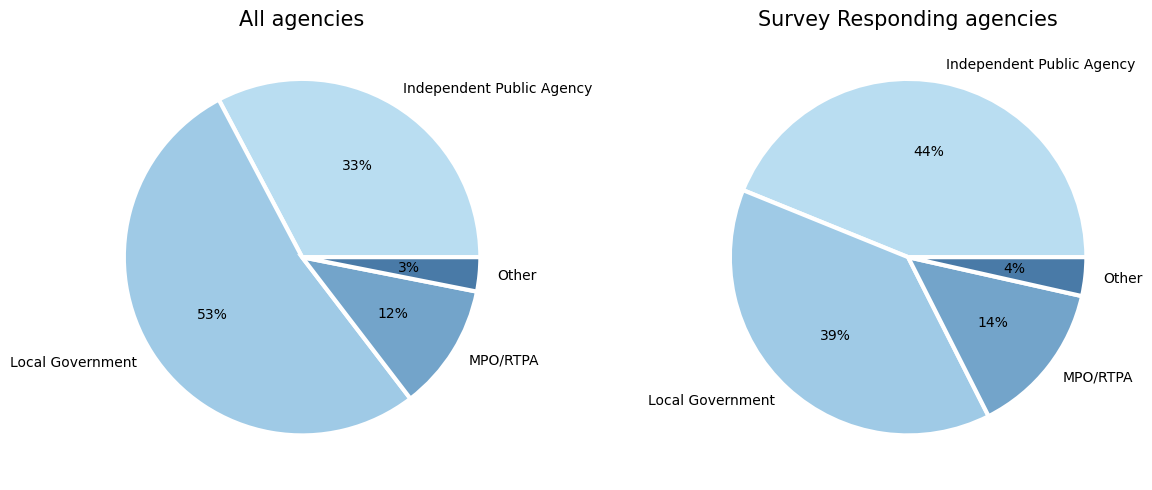

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plt.subplot(121)
plt.pie(transit_survey_video['OrgType'].value_counts().sort_index(), 
        labels = transit_survey_video['OrgType'].value_counts().sort_index().index.tolist(), 
        autopct='%.0f%%',
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
        colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"])
plt.title('All agencies', fontsize = 15)

plt.subplot(122)
plt.pie(responded['OrgType'].value_counts().sort_index(), 
        labels = responded['OrgType'].value_counts().sort_index().index.tolist(), 
        autopct='%.0f%%',
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
        colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"])
plt.title('Survey Responding agencies', fontsize = 15)

plt.tight_layout()

plt.savefig('Result/Survey type of agency.jpg', dpi = 300)

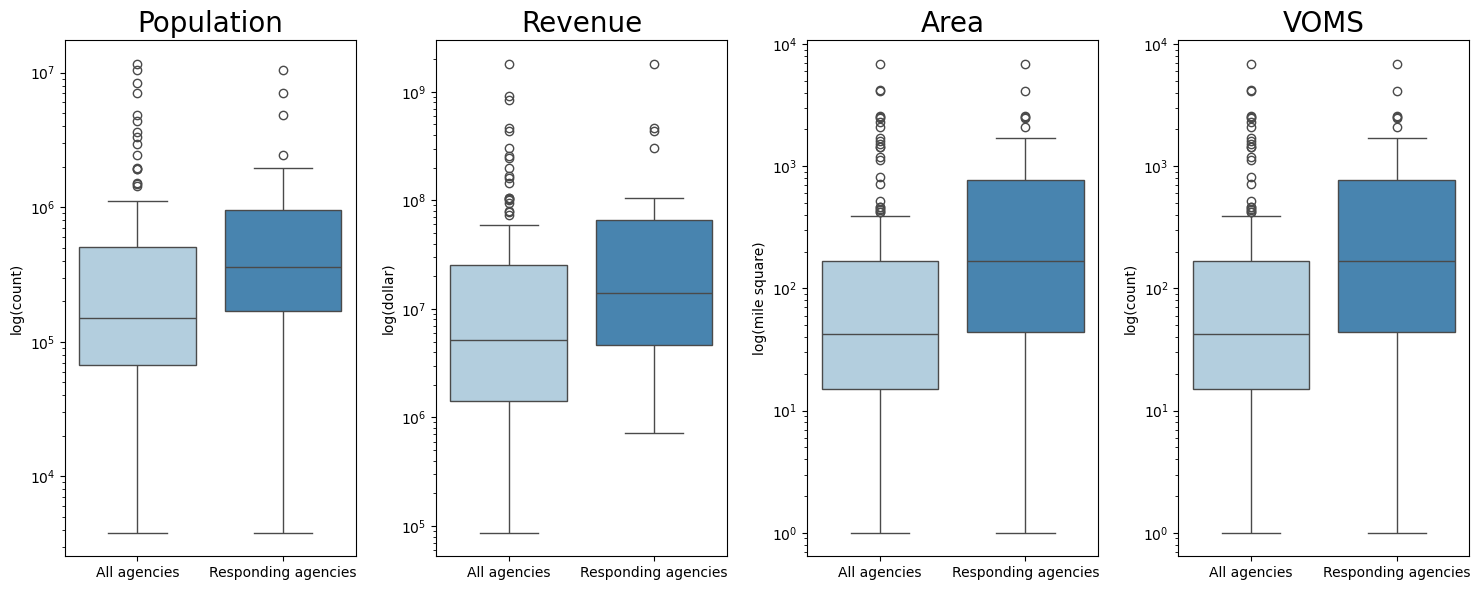

In [88]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6))

plt.subplot(141)
pop = pd.concat([transit_survey_video['pop'].reset_index(drop = True).rename('All agencies'),
                 responded['pop'].reset_index(drop = True).rename('Responding agencies')], axis = 1)
                #  no_response['pop'].reset_index(drop = True).rename('No_response')], axis = 1)
sns.boxplot(data = pop, palette="Blues")
plt.title('Population', fontsize = 20)
plt.ylabel('log(count)')
plt.yscale('log')

plt.subplot(142)
rev = pd.concat([transit_survey_video['revenue'].reset_index(drop = True).rename('All agencies'),
                 responded['revenue'].reset_index(drop = True).rename('Responding agencies')], axis = 1)
                #  no_response['pop'].reset_index(drop = True).rename('No_response')], axis = 1)
sns.boxplot(data = rev, palette="Blues")
plt.title('Revenue', fontsize = 20)
plt.ylabel('log(dollar)')
plt.yscale('log')

plt.subplot(143)
mile = pd.concat([transit_survey_video['mile'].reset_index(drop = True).rename('All agencies'),
                 responded['mile'].reset_index(drop = True).rename('Responding agencies')], axis = 1)
                #  no_response['pop'].reset_index(drop = True).rename('No_response')], axis = 1)
sns.boxplot(data = mile, palette="Blues")
plt.title('Area', fontsize = 20)
plt.ylabel('log(mile square)')
plt.yscale('log')

plt.subplot(144)
voms = pd.concat([transit_survey_video['VOMS'].reset_index(drop = True).rename('All agencies'),
                 responded['VOMS'].reset_index(drop = True).rename('Responding agencies')], axis = 1)
                #  no_response['pop'].reset_index(drop = True).rename('No_response')], axis = 1)
sns.boxplot(data = mile, palette="Blues")
plt.title('VOMS', fontsize = 20)
plt.ylabel('log(count)')
plt.yscale('log')

plt.tight_layout()

plt.savefig('Result/Survey agencies size.jpg', dpi = 300)

In [89]:
print ('population mean: ', np.mean(responded['pop']))
print ('revenue mean: ', np.mean(responded['revenue']))
print ('VOMS mean: ', np.mean(responded['VOMS']))
print ('area mean: ', np.mean(responded['mile']))

population mean:  1124654.7692307692
revenue mean:  101327563.74358974
VOMS mean:  141.19607843137254
area mean:  782.6410256410256


## Linear Regression

In [90]:
# Note that only NTD reporters have attributes (pop, mile, VOMS, revenue)

log_meta = np.log(transit_survey_video[['pop', 'mile', 'VOMS', 'revenue']]).dropna()
log_meta[['survey_response','post_video', 'minute_posted']] = transit_survey_video[['survey_response','post_video','minute_posted']]
log_meta

,pop,mile,VOMS,revenue,survey_response,post_video,minute_posted
0,13.673630,4.382027,6.238325,20.558102,0,1,1
1,13.124315,4.709530,4.510860,17.263339,0,0,1
2,12.521416,6.100319,4.382027,17.712266,0,1,1
3,12.511032,4.077537,4.276666,16.962968,0,1,1
4,13.659930,4.077537,4.852030,18.105685,1,1,1
...,...,...,...,...,...,...,...
138,12.533036,7.845416,2.197225,14.439113,1,1,1
188,13.558786,7.262629,5.634790,15.260130,0,1,0
189,12.317019,3.663562,3.610918,16.132056,0,1,1
190,11.859143,3.135494,3.583519,15.915293,0,1,0


In [91]:
'''
Y(survey_response) = a x log(pop) + c
'''

Y = log_meta['survey_response']
X = log_meta[['pop']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        survey_response   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     16.05
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           0.000101
Time:                        15:40:29   Log-Likelihood:                -78.317
No. Observations:                 139   AIC:                             160.6
Df Residuals:                     137   BIC:                             166.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8814      0.292     -3.015      0.003      -1.459      -0.303
pop            0.0956      0.024      4.006      0.000       0.048       0.143
==============================================================================
Omnibus:                       20.802   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.645
Skew:                           0.813   Prob(JB):                     8.94e-05
Kurtosis:                       2.242   Cond. No.                         99.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
'''
Y(survey_response) = a x log(revenue) + c
'''

Y = log_meta['survey_response']
X = log_meta[['revenue']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        survey_response   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     13.57
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           0.000330
Time:                        15:40:29   Log-Likelihood:                -79.454
No. Observations:                 139   AIC:                             162.9
Df Residuals:                     137   BIC:                             168.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7869      0.292     -2.694      0.008      -1.365      -0.209
revenue        0.0679      0.018      3.684      0.000       0.031       0.104
==============================================================================
Omnibus:                       26.855   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.005
Skew:                           0.815   Prob(JB):                     4.53e-05
Kurtosis:                       2.109   Cond. No.                         127.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
'''
Y(survey_response) = a x log(mile) + c
'''

Y = log_meta['survey_response']
X = log_meta[['mile']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        survey_response   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     25.54
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           1.36e-06
Time:                        15:40:29   Log-Likelihood:                -74.137
No. Observations:                 139   AIC:                             152.3
Df Residuals:                     137   BIC:                             158.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1019      0.083     -1.221      0.224      -0.267       0.063
mile           0.0948      0.019      5.054      0.000       0.058       0.132
==============================================================================
Omnibus:                       15.396   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.084
Skew:                           0.785   Prob(JB):                     0.000322
Kurtosis:                       2.439   Cond. No.                         11.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
'''
Y(survey_response) = a x log(VOMS) + c
'''

Y = log_meta['survey_response']
X = log_meta[['VOMS']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        survey_response   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     12.10
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           0.000676
Time:                        15:40:30   Log-Likelihood:                -80.135
No. Observations:                 139   AIC:                             164.3
Df Residuals:                     137   BIC:                             170.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0135      0.085      0.158      0.874      -0.155       0.182
VOMS           0.0816      0.023      3.479      0.001       0.035       0.128
==============================================================================
Omnibus:                       28.421   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.410
Skew:                           0.849   Prob(JB):                     2.24e-05
Kurtosis:                       2.098   Cond. No.                         8.92
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [95]:
'''
Y(survey_response) = a x log(pop) + b x log(revenue) + c
'''

Y = log_meta['survey_response']
X = log_meta[['pop', 'revenue']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        survey_response   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     8.297
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           0.000398
Time:                        15:40:30   Log-Likelihood:                -78.016
No. Observations:                 139   AIC:                             162.0
Df Residuals:                     136   BIC:                             170.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9490      0.306     -3.105      0.002      -1.553      -0.344
pop            0.0697      0.041      1.686      0.094      -0.012       0.151
revenue        0.0243      0.032      0.768      0.444      -0.038       0.087
==============================================================================
Omnibus:                       22.025   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.197
Skew:                           0.789   Prob(JB):                     0.000112
Kurtosis:                       2.192   Cond. No.                         169.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [96]:
'''
Y(survey_response) = a x log(pop) + b x log(mile) + c
'''

Y = log_meta['survey_response']
X = log_meta[['pop', 'mile']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        survey_response   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     12.71
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           8.70e-06
Time:                        15:40:30   Log-Likelihood:                -74.108
No. Observations:                 139   AIC:                             154.2
Df Residuals:                     136   BIC:                             163.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1879      0.371     -0.507      0.613      -0.922       0.546
pop            0.0090      0.038      0.238      0.812      -0.066       0.084
mile           0.0890      0.031      2.914      0.004       0.029       0.149
==============================================================================
Omnibus:                       15.197   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.877
Skew:                           0.780   Prob(JB):                     0.000357
Kurtosis:                       2.443   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Logistic Regression

In [97]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [98]:
def logit(Y, X):
    # convert y values to categorical values
    lab = preprocessing.LabelEncoder()
    y_transformed = lab.fit_transform(Y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.5, random_state=0)

    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    
    y_pred = logreg.predict(X_test)

    print(classification_report(y_test, y_pred))
    print('------------------------------------------------------')
    print(pd.DataFrame(logreg.coef_.transpose(),X.columns.tolist(),columns=['Coefficient']))

In [99]:
'''
X = pop, mile
'''
Y = log_meta['survey_response']
X = log_meta[['pop','mile']]
logit(Y,X)

              precision    recall  f1-score   support

           0       0.81      0.85      0.83        52
           1       0.50      0.44      0.47        18

    accuracy                           0.74        70
   macro avg       0.66      0.65      0.65        70
weighted avg       0.73      0.74      0.74        70

------------------------------------------------------
      Coefficient
pop     -0.258991
mile     0.684112


In [100]:
'''
X = pop, mile, revenue
'''
Y = log_meta['survey_response']
X = log_meta[['pop','mile', 'revenue']]
logit(Y,X)

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        52
           1       0.50      0.50      0.50        18

    accuracy                           0.74        70
   macro avg       0.66      0.66      0.66        70
weighted avg       0.74      0.74      0.74        70

------------------------------------------------------
         Coefficient
pop        -0.460379
mile        0.656309
revenue     0.200191


In [101]:
'''
X = pop, mile, VOMS, revenue
'''
Y = log_meta['survey_response']
X = log_meta[['pop','mile', 'VOMS', 'revenue']]
logit(Y,X)

              precision    recall  f1-score   support

           0       0.80      0.83      0.81        52
           1       0.44      0.39      0.41        18

    accuracy                           0.71        70
   macro avg       0.62      0.61      0.61        70
weighted avg       0.70      0.71      0.71        70

------------------------------------------------------
         Coefficient
pop        -0.453424
mile        0.668263
VOMS       -0.293875
revenue     0.384241


In [102]:
'''
X = mile, VOMS, revenue
'''
Y = log_meta['survey_response']
X = log_meta[['mile', 'VOMS', 'revenue']]
logit(Y,X)

              precision    recall  f1-score   support

           0       0.82      0.79      0.80        52
           1       0.45      0.50      0.47        18

    accuracy                           0.71        70
   macro avg       0.64      0.64      0.64        70
weighted avg       0.72      0.71      0.72        70

------------------------------------------------------
         Coefficient
mile        0.550933
VOMS       -0.284923
revenue     0.182404


# Minute Posting

## EDA

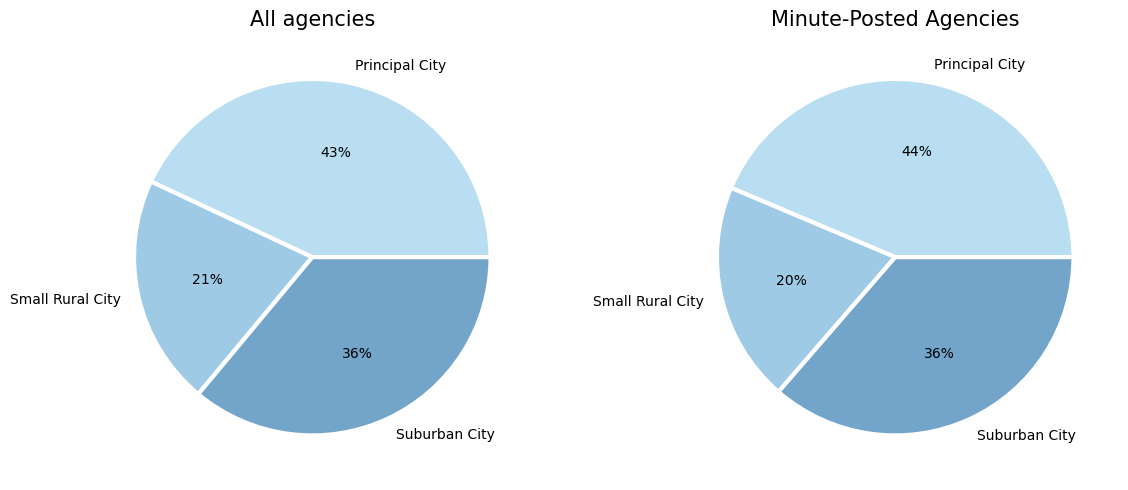

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plt.subplot(121)
plt.pie(transit_survey_video['id'].value_counts().sort_index(), 
    labels = transit_survey_video['id'].value_counts().sort_index().index.tolist(), 
    autopct='%.0f%%', 
    wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
    colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"])
plt.title('All agencies', fontsize = 15)

plt.subplot(122)
plt.pie(posted['id'].value_counts().sort_index(), 
    labels = posted['id'].value_counts().sort_index().index.tolist(), 
    autopct='%.0f%%', 
    wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
    colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"])
plt.title('Minute-Posted Agencies', fontsize = 15)

plt.tight_layout()

plt.savefig('Result/Meeting minutes type of city.jpg', dpi = 300)


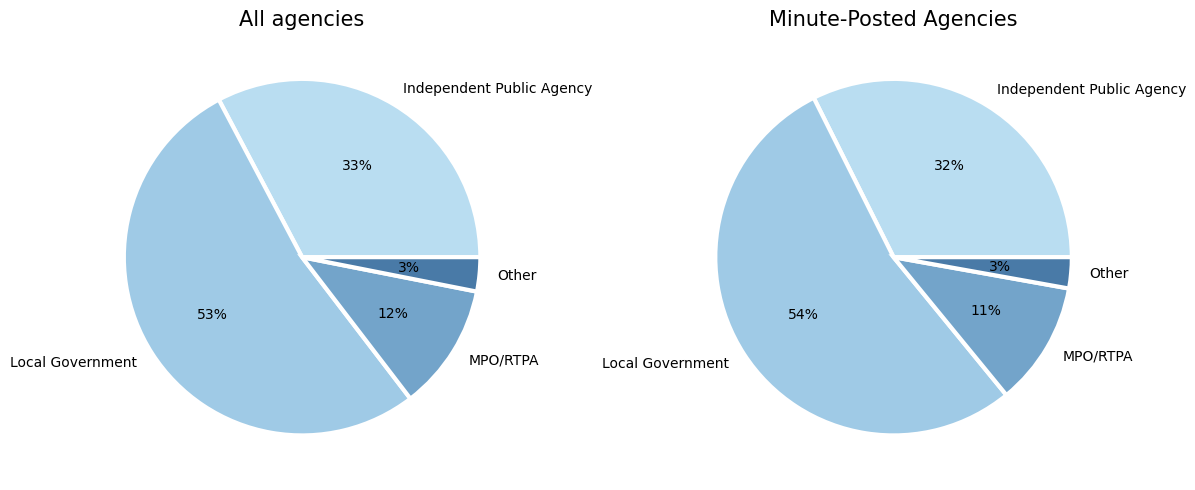

In [104]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plt.subplot(121)
plt.pie(transit_survey_video['OrgType'].value_counts().sort_index(), 
        labels = transit_survey_video['OrgType'].value_counts().sort_index().index.tolist(), 
        autopct='%.0f%%',
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
        colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"])
plt.title('All agencies', fontsize = 15)

plt.subplot(122)
plt.pie(posted['OrgType'].value_counts().sort_index(), 
        labels = posted['OrgType'].value_counts().sort_index().index.tolist(), 
        autopct='%.0f%%',
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
        colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"])
plt.title('Minute-Posted Agencies', fontsize = 15)

plt.tight_layout()

plt.savefig('Result/Meeting minute type of agency.jpg', dpi = 300)

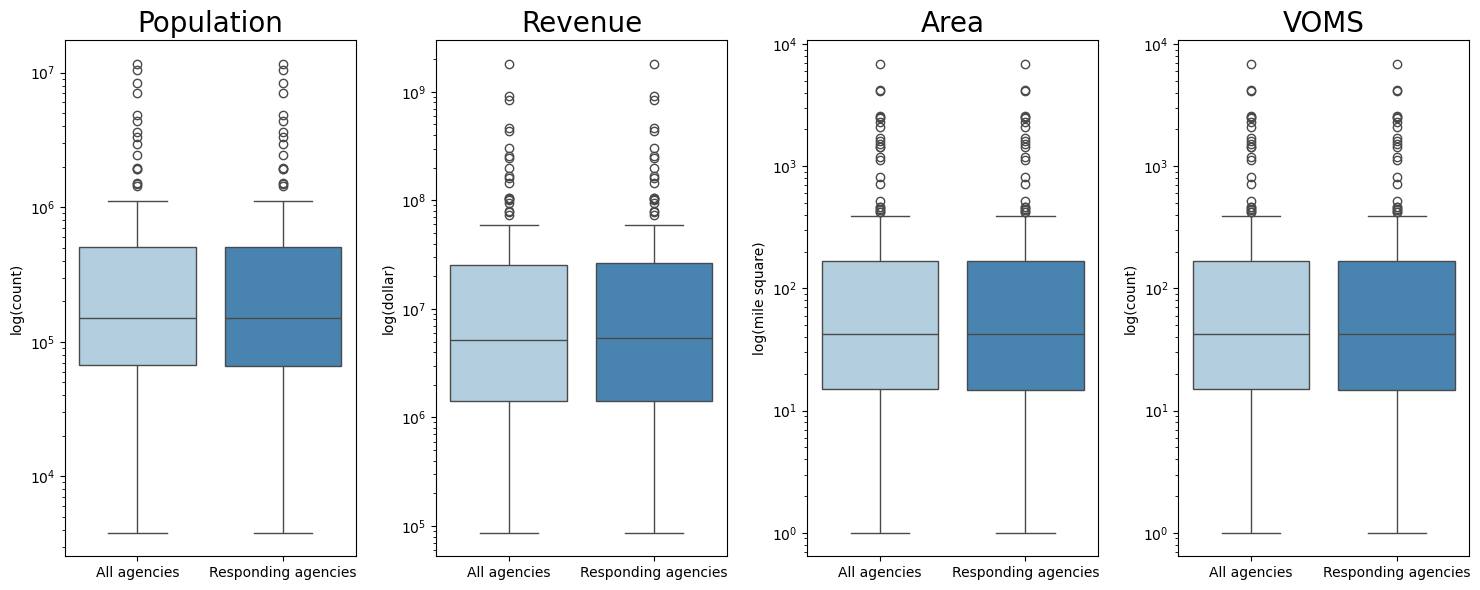

In [105]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6))

plt.subplot(141)
pop = pd.concat([transit_survey_video['pop'].reset_index(drop = True).rename('All agencies'),
                 posted['pop'].reset_index(drop = True).rename('Responding agencies')], axis = 1)
sns.boxplot(data = pop, palette="Blues")
plt.title('Population', fontsize = 20)
plt.ylabel('log(count)')
plt.yscale('log')

plt.subplot(142)
rev = pd.concat([transit_survey_video['revenue'].reset_index(drop = True).rename('All agencies'),
                 posted['revenue'].reset_index(drop = True).rename('Responding agencies')], axis = 1)
sns.boxplot(data = rev, palette="Blues")
plt.title('Revenue', fontsize = 20)
plt.ylabel('log(dollar)')
plt.yscale('log')

plt.subplot(143)
mile = pd.concat([transit_survey_video['mile'].reset_index(drop = True).rename('All agencies'),
                 posted['mile'].reset_index(drop = True).rename('Responding agencies')], axis = 1)
sns.boxplot(data = mile, palette="Blues")
plt.title('Area', fontsize = 20)
plt.ylabel('log(mile square)')
plt.yscale('log')

plt.subplot(144)
voms = pd.concat([transit_survey_video['VOMS'].reset_index(drop = True).rename('All agencies'),
                 posted['VOMS'].reset_index(drop = True).rename('Responding agencies')], axis = 1)
sns.boxplot(data = mile, palette="Blues")
plt.title('VOMS', fontsize = 20)
plt.ylabel('log(count)')
plt.yscale('log')

plt.tight_layout()

plt.savefig('Result/Meeting minute agencies size.jpg', dpi = 300)

In [106]:
print ('population mean: ', np.mean(posted['pop']))
print ('revenue mean: ', np.mean(posted['revenue']))
print ('VOMS mean: ', np.mean(posted['VOMS']))
print ('area mean: ', np.mean(posted['mile']))

population mean:  714343.0514705882
revenue mean:  55516128.85
VOMS mean:  77.88068181818181
area mean:  351.91911764705884


### Linear Regression

In [107]:
'''
Y(post_minute) = a x log(pop) + c
'''

Y = log_meta['minute_posted']
X = log_meta[['pop']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          minute_posted   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.2840
Date:                Thu, 18 Apr 2024   Prob (F-statistic):              0.595
Time:                        15:40:33   Log-Likelihood:                 71.020
No. Observations:                 139   AIC:                            -138.0
Df Residuals:                     137   BIC:                            -132.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0312      0.100     10.331      0.000       0.834       1.229
pop           -0.0043      0.008     -0.533      0.595      -0.020       0.012
==============================================================================
Omnibus:                      212.122   Durbin-Watson:                   1.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10817.015
Skew:                          -6.563   Prob(JB):                         0.00
Kurtosis:                      44.175   Cond. No.                         99.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
'''
Y(post_minute) = a x log(mile) + c
'''

Y = log_meta['minute_posted']
X = log_meta[['mile']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          minute_posted   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.5490
Date:                Thu, 18 Apr 2024   Prob (F-statistic):              0.460
Time:                        15:40:33   Log-Likelihood:                 71.154
No. Observations:                 139   AIC:                            -138.3
Df Residuals:                     137   BIC:                            -132.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9981      0.029     34.003      0.000       0.940       1.056
mile          -0.0049      0.007     -0.741      0.460      -0.018       0.008
==============================================================================
Omnibus:                      211.746   Durbin-Watson:                   1.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10739.131
Skew:                          -6.545   Prob(JB):                         0.00
Kurtosis:                      44.023   Cond. No.                         11.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
'''
Y(post_minute) = a x log(revenue) + c
'''

Y = log_meta['minute_posted']
X = log_meta[['revenue']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          minute_posted   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.1074
Date:                Thu, 18 Apr 2024   Prob (F-statistic):              0.744
Time:                        15:40:33   Log-Likelihood:                 70.931
No. Observations:                 139   AIC:                            -137.9
Df Residuals:                     137   BIC:                            -132.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9462      0.099      9.557      0.000       0.750       1.142
revenue        0.0020      0.006      0.328      0.744      -0.010       0.014
==============================================================================
Omnibus:                      212.389   Durbin-Watson:                   1.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10874.141
Skew:                          -6.576   Prob(JB):                         0.00
Kurtosis:                      44.286   Cond. No.                         127.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [110]:
'''
Y(post_minute) = a x log(VOMS) + c
'''

Y = log_meta['minute_posted']
X = log_meta[['VOMS']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          minute_posted   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9749
Date:                Thu, 18 Apr 2024   Prob (F-statistic):              0.325
Time:                        15:40:33   Log-Likelihood:                 71.369
No. Observations:                 139   AIC:                            -138.7
Df Residuals:                     137   BIC:                            -132.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0039      0.029     35.069      0.000       0.947       1.061
VOMS          -0.0078      0.008     -0.987      0.325      -0.023       0.008
==============================================================================
Omnibus:                      211.092   Durbin-Watson:                   1.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10600.391
Skew:                          -6.513   Prob(JB):                         0.00
Kurtosis:                      43.751   Cond. No.                         8.92
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Video Posting

## EDA

In [111]:
agency_video = transit_survey_video[transit_survey_video['count - video (past 12 months)'] >= 6]
agency_video.head()

,NTDID,AgencyName,OrgType,reptype,id,survey_response,City,County,Address,Zip,revenue,pop,mile,VOMS,NTD_21,minute_posted,count - video (past 12 months),post_video
0,90003.0,San Francisco Bay Area Rapid Transit District,Independent Public Agency,Full Reporter,Principal City,0,Oakland,Alameda,NaN,NaN,847755222.0,867725.0,80.0,512.0,1.0,1,37.0,1
2,90006.0,Santa Cruz Metropolitan Transit District,Independent Public Agency,Full Reporter,Principal City,0,Santa Cruz,Santa Cruz,110 Vernon Street,95060,49242398.0,274146.0,446.0,80.0,1.0,1,187.0,1
3,90007.0,Modesto,Local Government,Full Reporter,Principal City,0,Modesto,Stanislaus,PO Box 642,95354,23276818.0,271314.0,59.0,72.0,1.0,1,30.0,1
4,90008.0,Santa Monica,Local Government,Full Reporter,Principal City,1,Santa Monica,Los Angeles,NaN,NaN,72979162.0,855918.0,59.0,128.0,1.0,1,69.0,1
5,90009.0,San Mateo County Transit District,Independent Public Agency,Full Reporter,Suburban City,0,San Carlos,San Mateo,PO Box 1306,94070-1306,159261539.0,764442.0,97.0,303.0,1.0,1,36.0,1


In [112]:
print('Number of agencies: ',len(transit_survey_video))
print('Number of agencies that have revenue/pop/mile data: ', len(log_meta))
print('Number of agencies that post videos: ',len(agency_video))
print('Number of agencies that post videos and have revenue/pop/mile data: ', len(log_meta[log_meta['post_video']==1]))

Number of agencies:  226
Number of agencies that have revenue/pop/mile data:  139
Number of agencies that post videos:  126
Number of agencies that post videos and have revenue/pop/mile data:  89


About 70.59% Local Government is posting videos.
About 37.84% Independent Public Agency is posting videos.
About 53.85% MPO/RTPA is posting videos.


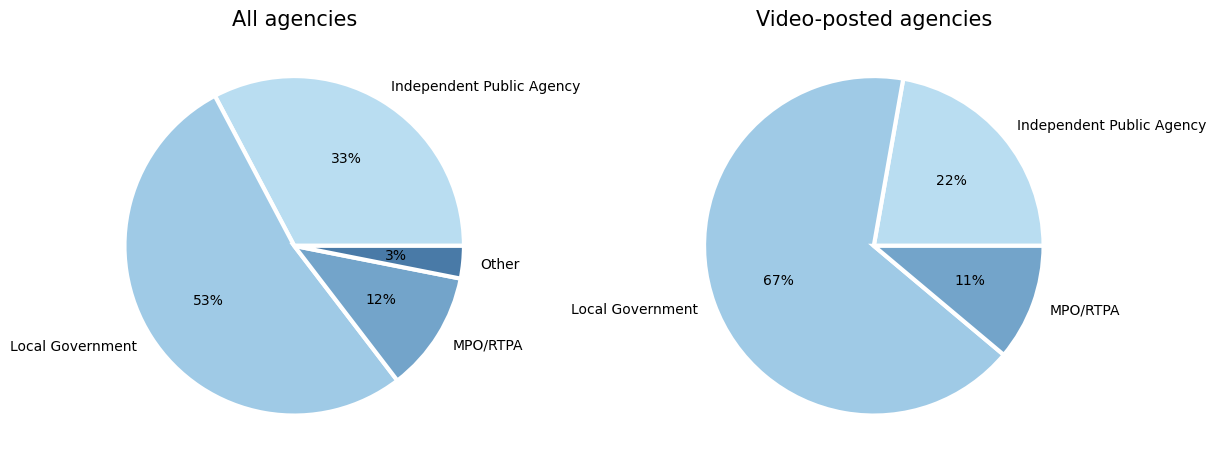

In [113]:
LG_PT = len(agency_video[agency_video['OrgType'] == 'Local Government'])/len(transit_survey_video[transit_survey_video['OrgType'] == 'Local Government'])
IPA_PT = len(agency_video[agency_video['OrgType'] == 'Independent Public Agency'])/len(transit_survey_video[transit_survey_video['OrgType'] == 'Independent Public Agency'])
MR_PT = len(agency_video[agency_video['OrgType'] == 'MPO/RTPA'])/len(transit_survey_video[transit_survey_video['OrgType'] == 'MPO/RTPA'])

print('About '+ format(LG_PT*100, '.2f') + '% Local Government is posting videos.')
print('About '+ format(IPA_PT*100, '.2f') + '% Independent Public Agency is posting videos.')
print('About '+ format(MR_PT*100, '.2f') + '% MPO/RTPA is posting videos.')


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plt.subplot(121)
plt.pie(transit_survey_video['OrgType'].value_counts().sort_index(), 
        labels = transit_survey_video['OrgType'].value_counts().sort_index().index.tolist(), 
        autopct='%.0f%%',
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
        colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"])
plt.title('All agencies', fontsize = 15)

plt.subplot(122)
plt.pie(agency_video['OrgType'].value_counts().sort_index(), 
        labels = agency_video['OrgType'].value_counts().sort_index().index.tolist(), 
        autopct='%.0f%%',
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
        colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"])

plt.title('Video-posted agencies', fontsize = 15)

plt.tight_layout()
plt.savefig('Result/Video type of agency.jpg', dpi = 300)

About 55.41% Principal City is posting videos.
About 59.68% Suburban City is posting videos.
About 52.78% Small Rural City is posting videos.


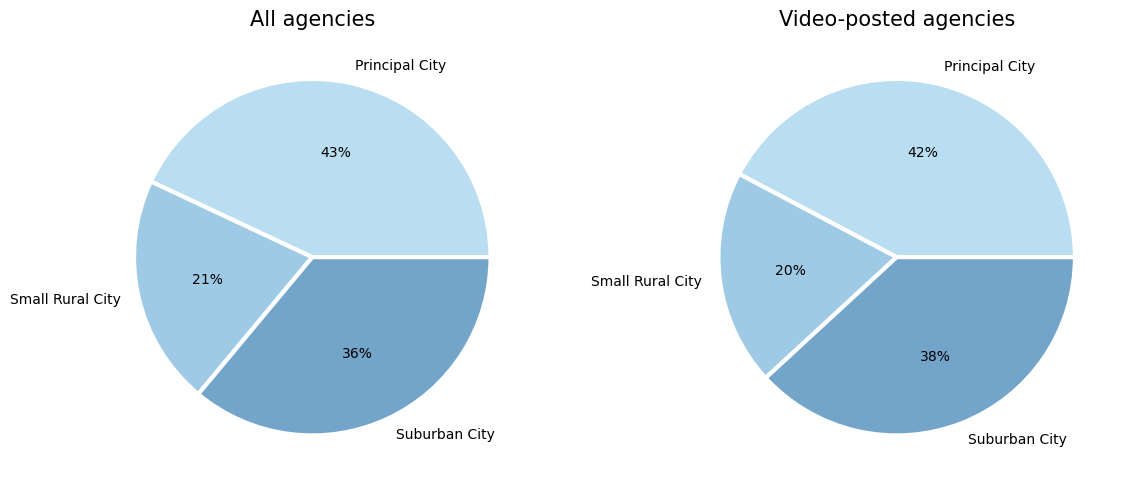

In [114]:
PC_PT = len(agency_video[agency_video['id'] == 'Principal City'])/len(transit_survey_video[transit_survey_video['id'] == 'Principal City'])
SR_PT = len(agency_video[agency_video['id'] == 'Suburban City'])/len(transit_survey_video[transit_survey_video['id'] == 'Suburban City'])
SC_PT = len(agency_video[agency_video['id'] == 'Small Rural City'])/len(transit_survey_video[transit_survey_video['id'] == 'Small Rural City'])

print('About '+ format(PC_PT*100, '.2f') + '% Principal City is posting videos.')
print('About '+ format(SR_PT*100, '.2f') + '% Suburban City is posting videos.')
print('About '+ format(SC_PT*100, '.2f') + '% Small Rural City is posting videos.')


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# fig.suptitle('Type of cities', fontsize = 20, ha='center',va='bottom')

plt.subplot(121)
plt.pie(transit_survey_video['id'].value_counts().sort_index(), 
    labels = transit_survey_video['id'].value_counts().sort_index().index.tolist(), 
    autopct='%.0f%%',
    wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
    colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"])
plt.title('All agencies', fontsize = 15)

plt.subplot(122)
plt.pie(agency_video['id'].value_counts().sort_index(), 
    labels = agency_video['id'].value_counts().sort_index().index.tolist(), 
    autopct='%.0f%%',
    wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' },
    colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"])
plt.title('Video-posted agencies', fontsize = 15)

plt.tight_layout()

plt.savefig('Result/Video type of city.jpg', dpi = 300)

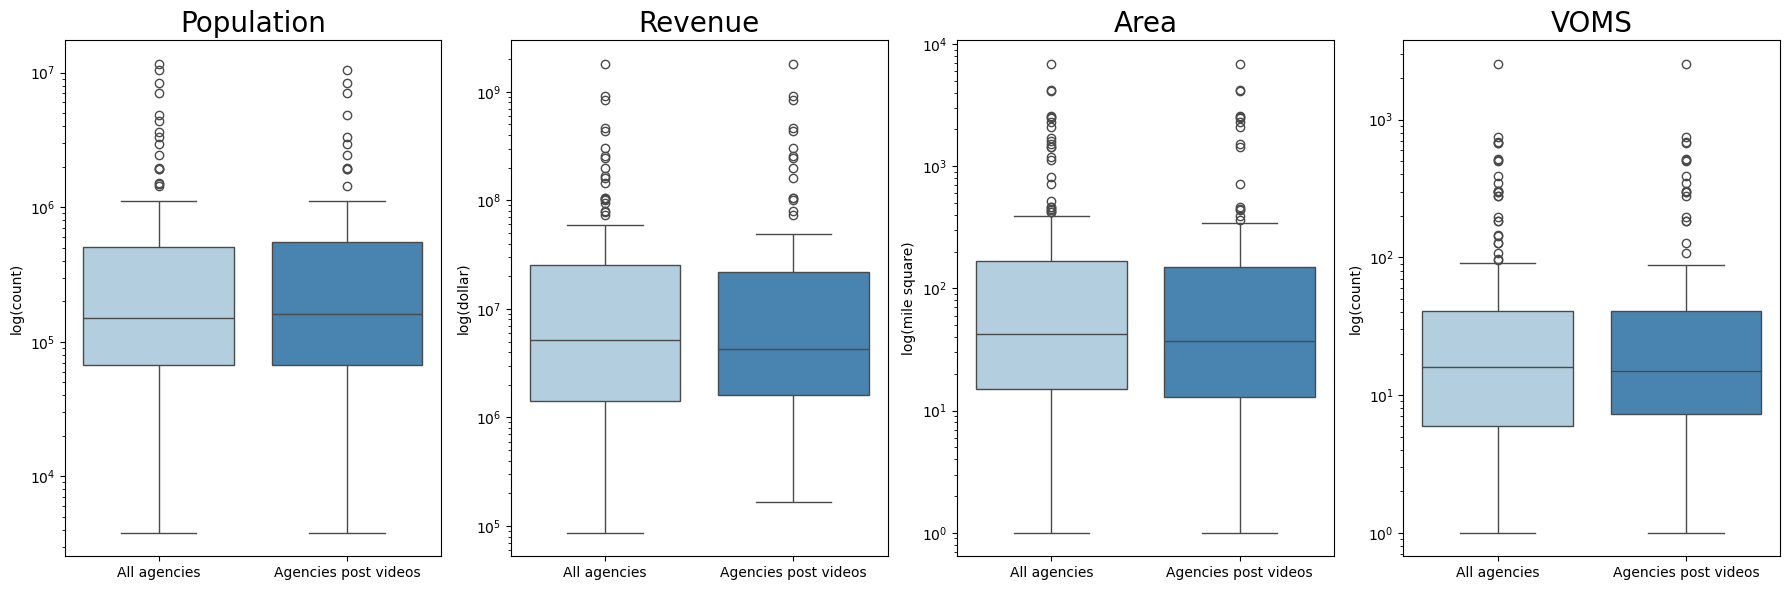

In [115]:
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

plt.subplot(141)
pop = pd.concat([transit_survey_video['pop'].reset_index(drop = True).rename('All agencies'),
                 agency_video['pop'].reset_index(drop = True).rename('Agencies post videos')], axis = 1)

sns.boxplot(data = pop, palette="Blues")
plt.title('Population', fontsize = 20)
plt.ylabel('log(count)')
plt.yscale('log')

plt.subplot(142)
rev = pd.concat([transit_survey_video['revenue'].reset_index(drop = True).rename('All agencies'),
                 agency_video['revenue'].reset_index(drop = True).rename('Agencies post videos')], axis = 1)

sns.boxplot(data = rev, palette="Blues")
plt.title('Revenue', fontsize = 20)
plt.ylabel('log(dollar)')
plt.yscale('log')

plt.subplot(143)
mile = pd.concat([transit_survey_video['mile'].reset_index(drop = True).rename('All agencies'),
                 agency_video['mile'].reset_index(drop = True).rename('Agencies post videos')], axis = 1)

sns.boxplot(data = mile, palette="Blues")
plt.title('Area', fontsize = 20)
plt.ylabel('log(mile square)')
plt.yscale('log')

plt.subplot(144)
mile = pd.concat([transit_survey_video['VOMS'].reset_index(drop = True).rename('All agencies'),
                 agency_video['VOMS'].reset_index(drop = True).rename('Agencies post videos')], axis = 1)

sns.boxplot(data = mile, palette="Blues")
plt.title('VOMS', fontsize = 20)
plt.ylabel('log(count)')
plt.yscale('log')

plt.tight_layout()

plt.savefig('Result/video agencies size.jpg', dpi = 300)

In [116]:
print ('population mean: ', np.mean(agency_video['pop']))
print ('revenue mean: ', np.mean(agency_video['revenue']))
print ('VOMS mean: ', np.mean(agency_video['VOMS']))
print ('area mean: ', np.mean(agency_video['mile']))

population mean:  748181.1910112359
revenue mean:  73178044.72527473
VOMS mean:  99.9245283018868
area mean:  412.2584269662921


## Linear Regression

In [117]:
'''
Y(post_video) = a x log(pop) + c
'''

Y = log_meta['post_video']
X = log_meta[['pop']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             post_video   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.3350
Date:                Thu, 18 Apr 2024   Prob (F-statistic):              0.564
Time:                        15:40:38   Log-Likelihood:                -95.017
No. Observations:                 139   AIC:                             194.0
Df Residuals:                     137   BIC:                             199.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4510      0.330      1.368      0.173      -0.201       1.103
pop            0.0156      0.027      0.579      0.564      -0.038       0.069
==============================================================================
Omnibus:                     1696.821   Durbin-Watson:                   1.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.629
Skew:                          -0.582   Prob(JB):                     7.40e-06
Kurtosis:                       1.349   Cond. No.                         99.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [118]:
'''
Y(post_video) = a x log(revenue) + c
'''

Y = log_meta['post_video']
X = log_meta[['revenue']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             post_video   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                   0.06347
Date:                Thu, 18 Apr 2024   Prob (F-statistic):              0.801
Time:                        15:40:39   Log-Likelihood:                -95.154
No. Observations:                 139   AIC:                             194.3
Df Residuals:                     137   BIC:                             200.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5585      0.327      1.708      0.090      -0.088       1.205
revenue        0.0052      0.021      0.252      0.801      -0.036       0.046
==============================================================================
Omnibus:                     1653.127   Durbin-Watson:                   1.719
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.802
Skew:                          -0.584   Prob(JB):                     6.78e-06
Kurtosis:                       1.343   Cond. No.                         127.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [119]:
'''
Y(post_video) = a x log(mile) + c
'''

Y = log_meta['post_video']
X = log_meta[['mile']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             post_video   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7999
Date:                Thu, 18 Apr 2024   Prob (F-statistic):              0.373
Time:                        15:40:39   Log-Likelihood:                -94.782
No. Observations:                 139   AIC:                             193.6
Df Residuals:                     137   BIC:                             199.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7188      0.097      7.421      0.000       0.527       0.910
mile          -0.0195      0.022     -0.894      0.373      -0.062       0.024
==============================================================================
Omnibus:                     1775.171   Durbin-Watson:                   1.715
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.314
Skew:                          -0.577   Prob(JB):                     8.66e-06
Kurtosis:                       1.359   Cond. No.                         11.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [120]:
'''
Y(post_video) = a x log(VOMS) + c
'''

Y = log_meta['post_video']
X = log_meta[['VOMS']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             post_video   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7332
Date:                Thu, 18 Apr 2024   Prob (F-statistic):              0.393
Time:                        15:40:39   Log-Likelihood:                -94.815
No. Observations:                 139   AIC:                             193.6
Df Residuals:                     137   BIC:                             199.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5672      0.095      5.994      0.000       0.380       0.754
VOMS           0.0223      0.026      0.856      0.393      -0.029       0.074
==============================================================================
Omnibus:                     1775.732   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.399
Skew:                          -0.580   Prob(JB):                     8.30e-06
Kurtosis:                       1.359   Cond. No.                         8.92
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [121]:
'''
Y(post_video) = a x log(pop) + b x log(revenue) + c
'''

Y = log_meta['post_video']
X = log_meta[['pop', 'revenue']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             post_video   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.2385
Date:                Thu, 18 Apr 2024   Prob (F-statistic):              0.788
Time:                        15:40:40   Log-Likelihood:                -94.943
No. Observations:                 139   AIC:                             195.9
Df Residuals:                     136   BIC:                             204.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4887      0.345      1.416      0.159      -0.194       1.171
pop            0.0300      0.047      0.643      0.521      -0.062       0.122
revenue       -0.0136      0.036     -0.380      0.705      -0.084       0.057
==============================================================================
Omnibus:                     1707.063   Durbin-Watson:                   1.724
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.535
Skew:                          -0.579   Prob(JB):                     7.75e-06
Kurtosis:                       1.351   Cond. No.                         169.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [122]:
'''
Y(post_video) = a x log(pop) + b x log(mile) + c
'''

Y = log_meta['post_video']
X = log_meta[['pop', 'mile']]
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             post_video   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.640
Date:                Thu, 18 Apr 2024   Prob (F-statistic):             0.0750
Time:                        15:40:40   Log-Likelihood:                -92.539
No. Observations:                 139   AIC:                             191.1
Df Residuals:                     136   BIC:                             199.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1526      0.424     -0.360      0.719      -0.990       0.685
pop            0.0910      0.043      2.112      0.037       0.006       0.176
mile          -0.0775      0.035     -2.222      0.028      -0.146      -0.009
==============================================================================
Omnibus:                      450.562   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.784
Skew:                          -0.594   Prob(JB):                     3.07e-05
Kurtosis:                       1.525   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Correlation Plot

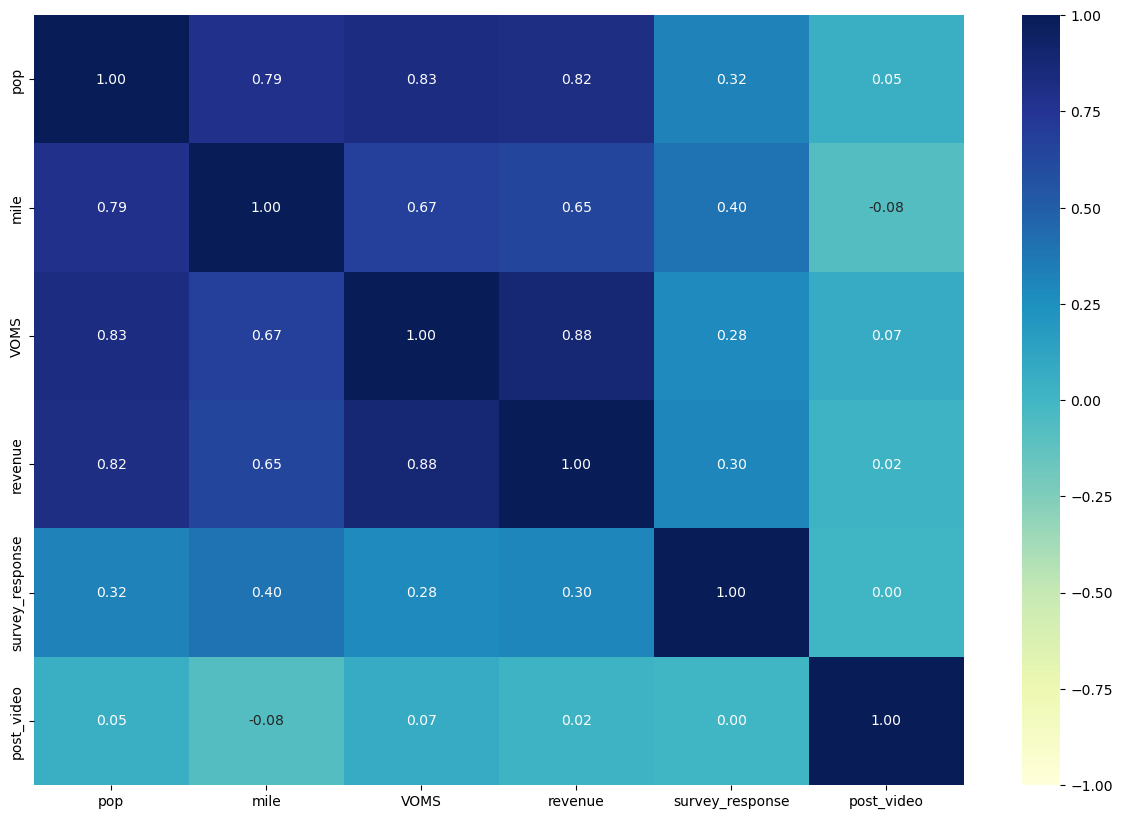

In [123]:
plt.figure(figsize=[15, 10])
corr_matrix = log_meta[['pop','mile', 'VOMS', 'revenue', 'survey_response', 'post_video']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", vmin=-1, vmax=1, fmt = '.2f')

plt.savefig('Result/correlation matrix all.jpg', dpi = 300)
plt.show()

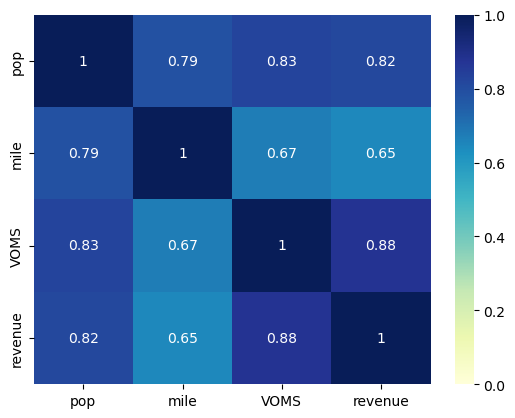

In [124]:
corr_matrix = log_meta[['pop','mile', 'VOMS', 'revenue']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", vmin=0, vmax=1)
plt.savefig('Result/correlation matrix.jpg', dpi = 300)